In [1]:
## Creation of data
import numpy as np
n_samples = 200
X = np.linspace(-5, 5, n_samples).reshape(-1, 1)
true_slope = 2.0
true_intercept = 1.0
y = true_slope * X + true_intercept + 0.1 * np.random.normal(size=(n_samples,1))
y = y.ravel()  # Flatten to 1D array

print(X.shape)
print(y.shape)

(200, 1)
(200,)


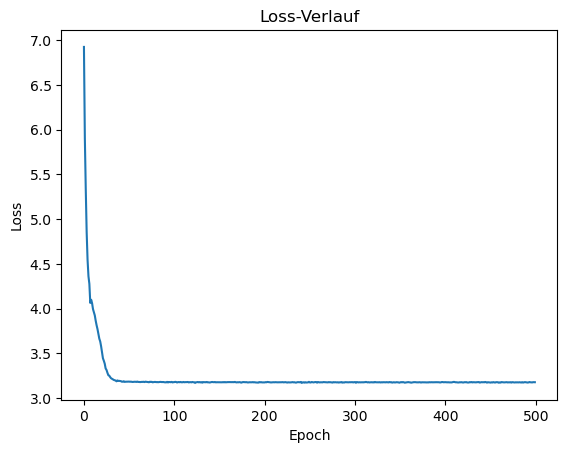

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


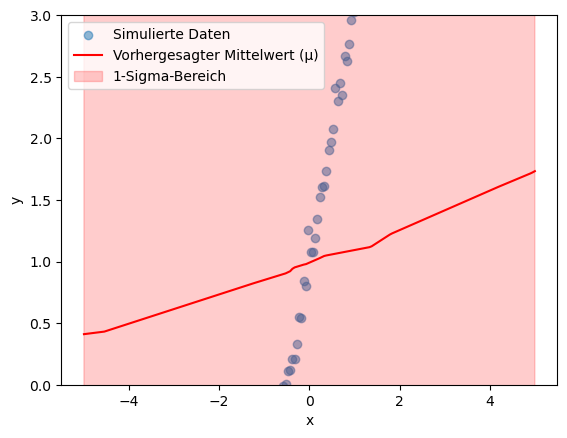

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1584
3.0925443172454834


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # Set backend to JAX

import jax.numpy as jnp
from keras import layers, models
import matplotlib.pyplot as plt

# 🚩 Modell: Vorhersage von μ (Mittelwert) und log(σ) (Standardabweichung)
model = models.Sequential([
    layers.InputLayer(shape=(1,)),  # 1 Merkmal (x)
    layers.Dense(10, activation="relu"),  # 1 Merkmal (x)
    layers.Dense(10, activation="relu"),
    layers.Dense(2)  # Zwei Ausgänge: μ und log(σ)
])

def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0:1]  # Vorhergesagter Mittelwert
    log_sigma = y_pred[:, 1:2]  # Vorhergesagte log(σ)
    sigma = jnp.exp(log_sigma)  # σ muss positiv sein
    # Berechnung des NLL
    nll = 0.5 * jnp.log(2 * jnp.pi) + log_sigma + ((y_true - mu) ** 2) / (2 * sigma ** 2)
    return jnp.mean(nll)

model.compile(optimizer="adam", loss=nll_loss)

history = model.fit(X, y, batch_size=16, epochs=500, verbose=0)

plt.plot(history.history['loss'])
plt.title("Loss-Verlauf")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

y_pred = model.predict(X)
mu_pred = y_pred[:, 0]  # Vorhergesagte Mittelwerte
sigma_pred = jnp.exp(y_pred[:, 1])  # Vorhergesagte Standardabweichungen

# 🚩 Visualisierung der Vorhersagen
plt.scatter(X, y, label="Simulierte Daten", alpha=0.5)
plt.plot(X, mu_pred, color="red", label="Vorhergesagter Mittelwert (μ)")
plt.fill_between(
    X.flatten(),
    (mu_pred - sigma_pred).flatten(),
    (mu_pred + sigma_pred).flatten(),
    color="red",
    alpha=0.2,
    label="1-Sigma-Bereich"
)
plt.ylim(0,5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

print(model.evaluate)

Epoch 1/10


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.7611
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.6165
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.6770
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.6572
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.2984
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.2614
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.2518
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.1576
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.8842
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.8612


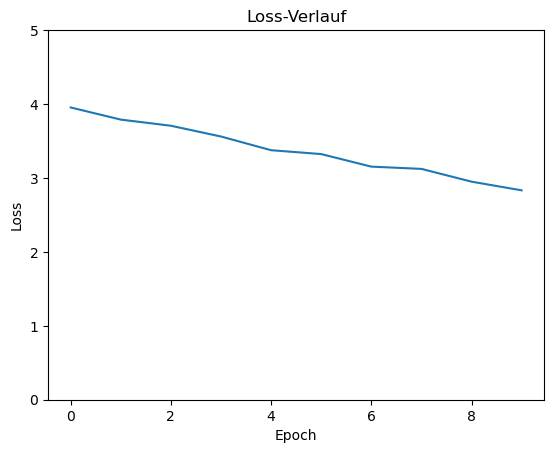

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1563
2.0680110454559326


In [3]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" #Needed on MAC to avoid MPS error (22 Nov 2024)
os.environ["KERAS_BACKEND"] = "torch"  # Set backend to PyTorch

import torch
from torch import exp, log, pi
from keras import layers, models
import matplotlib.pyplot as plt

Xt = torch.tensor(X, dtype=torch.float32)
yt = torch.tensor(y, dtype=torch.float32)

model = models.Sequential([
    layers.InputLayer(shape=(1,)),  # 1 Merkmal (x)
    layers.Dense(10, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(2)  # Zwei Ausgänge: μ und log(σ)
])

def nll_loss(y_true, y_pred):
    mu = y_pred[:, 0:1]  # Vorhergesagter Mittelwert
    log_sigma = y_pred[:, 1:2]  # Vorhergesagte log(σ)
    sigma = exp(log_sigma)  # σ muss positiv sein
    # Berechnung des NLL
    nll = log_sigma + ((y_true - mu) ** 2) / (2 * sigma ** 2)
    return torch.mean(nll)

model.compile(optimizer="adam", loss=nll_loss)

history = model.fit(Xt, yt, batch_size=16, epochs=10, verbose=1)

# 🚩 Visualisierung des Loss-Verlaufs
plt.plot(history.history['loss'])
plt.title("Loss-Verlauf")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0,5)
plt.show()

print(model.evaluate(Xt, yt))


In [9]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # Set backend to JAX

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import jax.numpy as jnp
from keras import layers, models

# Load the Iris dataset
data = load_iris()
X = data['data']  # Features: sepal/petal length & width
y = data['target']  # Labels: 0 (Setosa), 1 (Versicolor), 2 (Virginica)

# Binary classification setup: Simplify the task to "Setosa" (0) vs "Not Setosa" (1)
y = (y == 0).astype(int)  # 0 for Setosa, 1 for others

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
X_test = jnp.array(X_test, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)#.reshape(-1, 1)  # Binary classification expects (N, 1)
y_test = jnp.array(y_test, dtype=jnp.float32)#.reshape(-1, 1)

print("Data Shapes:", X_train.shape, y_train.shape)  # (120, 4), (120, 1)

# Define a simple binary classification model
model = models.Sequential([
    layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),  # 4 features
    layers.Dense(1, activation='sigmoid')  # Output shape: (N, 1)
])

# Compile the model (using JAX-compatible loss and optimizer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, verbose=0)

# Evaluate the model on the training set
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Train Loss: {loss:.4f}, Train Accuracy: {accuracy:.4f}")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Data Shapes: (120, 4) (120,)
Train Loss: 0.0706, Train Accuracy: 1.0000
Test Loss: 0.0714, Test Accuracy: 1.0000
